<a href="https://colab.research.google.com/github/sadberyy/ChinaStockMarket/blob/main/Temporary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyPortfolioOpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.cla import CLA
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.discrete_allocation import get_latest_prices
import pypfopt.plotting as pplt #Возникают проблемы с plt.style.use("seaborn-deep"). Для решения нужно в самом файле изменить строку на plt.style.use("seaborn-v0_8-deep")
from matplotlib.ticker import FuncFormatter

## **Portfolio with minimal risk**

In [ ]:
df_stocks = pd.read_excel('outputHKstocks.xlsx')
mu = expected_returns.mean_historical_return(df_stocks)
tickers, weight_1, weight_2, weight_3 = [], [], [], []
Sigma = risk_models.sample_cov(df_stocks)#Дисперсия портфеля
#Sigma = risk_models.CovarianceShrinkage(df_stocks).ledoit_wolf()
ef50_s = EfficientFrontier(mu, Sigma, weight_bounds=(-1,1)) #weight bounds in negative allows shorting of stocks
minvol=ef50_s.min_volatility()
minvol_pwt=ef50_s.clean_weights()
for i in minvol_pwt:
    tickers.append(i)
    weight_1.append(minvol_pwt[i])
ef50_s.portfolio_performance(verbose=True)
performance = ef50_s.portfolio_performance()
return50_s, volatility50_s = performance[:2]

ef50_l = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in positive allows longing of stocks
minvol=ef50_l.min_volatility()
minvol_pwt=ef50_l.clean_weights()
for i in minvol_pwt:
    weight_2.append(minvol_pwt[i])
ef50_l.portfolio_performance(verbose=True)
performance = ef50_l.portfolio_performance()
return50_l, volatility50_l = performance[:2]

data = pd.DataFrame({'ticker': tickers, 'weight_1': weight_1, 'weight_2': weight_2})
data.to_excel('outputPortfolio.xlsx', index=False)

Expected annual return: 12.5%
Annual volatility: 9.4%
Sharpe Ratio: 1.12
Expected annual return: 13.7%
Annual volatility: 11.8%
Sharpe Ratio: 0.99


Портфель с запретом коротких продаж показывает более высокую ожидаемую доходность по сравнению с портфелем, где короткие продажи разрешены. Это может указывать на то, что активы, которые были исключены из портфеля из-за запрета на короткие позиции, могли иметь либо отрицательную доходность, либо были высокорисковыми активами, что в итоге повысило ожидаемую доходность портфеля без шортов. Портфель с разрешением коротких продаж имеет меньшую волатильность по сравнению с портфелем без коротких продаж. Это объясняется тем, что короткие продажи могут использоваться для хеджирования рисков, что позволяет снизить общую волатильность портфеля.

## **Efficient frontier**


Expected annual return: 20.6%
Annual volatility: 18.0%
Sharpe Ratio: 1.03


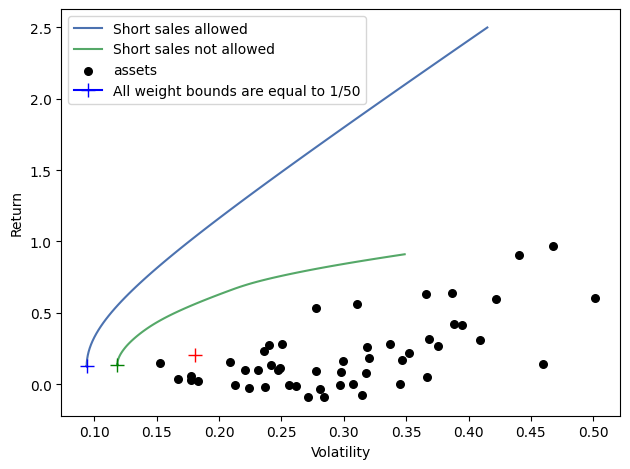

<Figure size 640x480 with 0 Axes>

In [ ]:
ef = EfficientFrontier(mu, Sigma, weight_bounds=(1/50, 1/50)) #All weight bounds are equal to 1/50
minvol=ef.min_volatility()
ef.portfolio_performance(verbose=True)
performance = ef.portfolio_performance()
return3, volatility3 = performance[:2]

fig, ax = plt.subplots()

ef50_s = EfficientFrontier(mu, Sigma, weight_bounds=(-1, 1))
plotting.plot_efficient_frontier(ef50_s, ax=ax, show_assets=False, ef_param_range=np.linspace(0.00, 2.50, 100))

ef50_l = EfficientFrontier(mu, Sigma, weight_bounds=(0, 1))
plotting.plot_efficient_frontier(ef50_l, ax=ax, show_assets=True, ef_param_range=np.linspace(0.00, 0.91, 100))

plt.plot([volatility50_s], [return50_s], marker='+', color='blue', markerfacecolor='red', markersize=10)
plt.plot([volatility50_l], [return50_l], marker='+', color='green', markerfacecolor='red', markersize=10)
plt.plot([volatility3], [return3], marker='+', color='red', markerfacecolor='red', markersize=10)


plt.legend(['Short sales allowed','Short sales not allowed', 'assets', 'All weight bounds are equal to 1/50'])
plt.show()
plt.savefig('Efficient_frontiers.png')

*   Когда короткие продажи разрешены, это дает возможность снизить риск, "шортя" активы, которые, по нашим ожиданиям, будут снижаться в цене. Это делает стратегию более гибкой, позволяет эффективно хеджировать риски. Фронт с короткими продажами предоставляет более широкий диапазон возможных комбинаций.
*   А когда короткие продажи запрещены, нельзя хеджировать активы с высоким риском, поэтому приходится выбирать активы, которые будут наиболее стабильными, чтобы снизить общий риск. Фронт без коротких продаж ограничивает портфель, что в реальных условиях может быть более практичным для большинства инвесторов, но снижает возможности для получения более высокой доходности.
*   Портфель с равными долями является "базовым" портфелем, в котором игнорируются различия в волатильности и корреляции активов, что приводит к менее эффективному распределению рисков и доходности. Он предполагает, что все активы одинаково важны для портфеля, что делает его точкой отсчета, ориентиром для сравнения с эффективными портфелями. Например, у нас есть два актива: А и Б. У актива А большой риск, а у актива Б небольшой. Чтобы снизить риск у актива А, мы сделаем его долю равной 1/50 – 1/60. А активу Б дадим долю 1/50 + 1/60. И А и Б пусть имеют одинаковую эффективность. Тогда наш «+» сдвинется влево. Равные доли могут показывать инвестору, как много он упускает в плане потенциальной доходности, если он не использует более сложные методы оптимизации.





## **Portfolio selection problem**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter
#!pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter
from pypfopt.discrete_allocation import get_latest_prices
from pypfopt.discrete_allocation import DiscreteAllocation
import yfinance as yf


Чтобы выбрать 10 портфелей из 50 мы использовали итеративный локальный поиск. Итеративный локальный поиск – это метод оптимизации, который использует последовательные небольшие модификации текущего решения, чтобы найти лучшее решение. На каждом шаге метода удаляется один актив и добавляется другой, при этом проверяется, улучшает ли это портфель в плане ожидаемой доходности и риска. Сперва с его помощью мы выбрали портфель из заданного набора активов, а далее выбрали 10 активов с самыми большими получившимися весами.

In [ ]:
def portfolio_optimization(returns, cov_matrix, num_assets=10, max_iter=100, short_selling=True):
  """
  Итеративный локальный поиск для выбора портфеля из num_assets активов.

  Args:
    returns: Матрица доходности активов (N x T), где N - количество активов, T - количество периодов.
    cov_matrix: Ковариационная матрица доходности активов (N x N).
    num_assets: Количество активов в портфеле.
    max_iter: Максимальное количество итераций.
    short_selling: Разрешены ли короткие продажи (True/False).

  Returns:
    selected_assets: Список из num_assets выбранных активов.
    weights: Вектор весов портфеля (N).
    portfolio_return: Ожидаемая доходность портфеля.
    portfolio_risk: Стандартное отклонение доходности портфеля.
  """

  n_assets = returns.shape[0]
  # Инициализация случайного портфеля
  weights = np.random.rand(n_assets)
  weights /= np.sum(weights)

  # Ограничения на веса
  if not short_selling:
    weights = np.clip(weights, 0, 1)
  # Итеративный локальный поиск
  for _ in range(max_iter):
    for i in range(n_assets):
      # Удаление текущего актива из портфеля
      temp_weights = weights.copy()
      temp_weights[i] = 0

      # Проверка остальных активов
      for j in range(n_assets):
        if j == i or temp_weights[j] > 0:
          continue

        # Добавление актива j в портфель
        temp_weights[j] = 1 - np.sum(temp_weights)

        # Ограничения на веса
        if not short_selling:
          temp_weights = np.clip(temp_weights, 0, 1)

        # Вычисление доходности и риска портфеля
        portfolio_return = np.dot(temp_weights, np.mean(returns, axis=1))
        portfolio_risk = np.sqrt(np.dot(temp_weights.T, np.dot(cov_matrix, temp_weights)))

        # Обновление весов, если найден лучший вариант
        if portfolio_return > np.dot(weights, np.mean(returns, axis=1)) and portfolio_risk < np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))):
          weights = temp_weights.copy()

  # Вычисление окончательной доходности и риска портфеля
  portfolio_return = np.dot(weights, np.mean(returns, axis=1))
  portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

  # Выбор 10 активов с наибольшими весами
  selected_assets = np.argsort(weights)[-num_assets:]

  return selected_assets, weights, portfolio_return, portfolio_risk

# Загрузка тикеров из Excel-файла
tickers = pd.read_excel('/content/tickers.xlsx', usecols=["ticker"])["ticker"].tolist()

# Загрузка исторических данных по 50 активам
data = yf.download(tickers, start="2016-01-01", end="2016-12-31")["Adj Close"]

# Вычисление доходности
returns = data.pct_change().dropna()

# Вычисление ковариационной матрицы
cov_matrix = returns.cov()

# Оптимизация портфеля с короткими продажами
selected_assets_short, weights_short, return_short, risk_short = portfolio_optimization(returns.values[:50], cov_matrix.values, short_selling=True)

# Оптимизация портфеля без коротких продаж
selected_assets_long, weights_long, return_long, risk_long = portfolio_optimization(returns.values[:50], cov_matrix.values, short_selling=False)

# Вывод результатов
print("Портфель с короткими продажами:")
print("Выбранные активы:", [tickers[i] for i in selected_assets_short])

print("\nПортфель без коротких продаж:")
print("Выбранные активы:", [tickers[i] for i in selected_assets_long])

[*********************100%***********************]  50 of 50 completed


Портфель с короткими продажами:
Выбранные активы: ['0960.HK', '0017.HK', '2382.HK', '0669.HK', '0981.HK', '1088.HK', '0881.HK', '0388.HK', '0011.HK', '0003.HK']

Портфель без коротких продаж:
Выбранные активы: ['0016.HK', '0386.HK', '2388.HK', '0881.HK', '0175.HK', '0883.HK', '2318.HK', '0857.HK', '0939.HK', '0285.HK']


In [ ]:
tickers_10_short = [tickers[i] for i in selected_assets_short]
tickers_10_long = [tickers[i] for i in selected_assets_long]
print("long")
print(tickers_10_long)
print("short")
print(tickers_10_short)

long
['0016.HK', '0386.HK', '2388.HK', '0881.HK', '0175.HK', '0883.HK', '2318.HK', '0857.HK', '0939.HK', '0285.HK']
short
['0960.HK', '0017.HK', '2382.HK', '0669.HK', '0981.HK', '1088.HK', '0881.HK', '0388.HK', '0011.HK', '0003.HK']


Случай, когда короткие продажи не запрещены:

[*********************100%***********************]  10 of 10 completed


Expected annual return: -0.4%
Annual volatility: 14.0%
Sharpe Ratio: -0.17


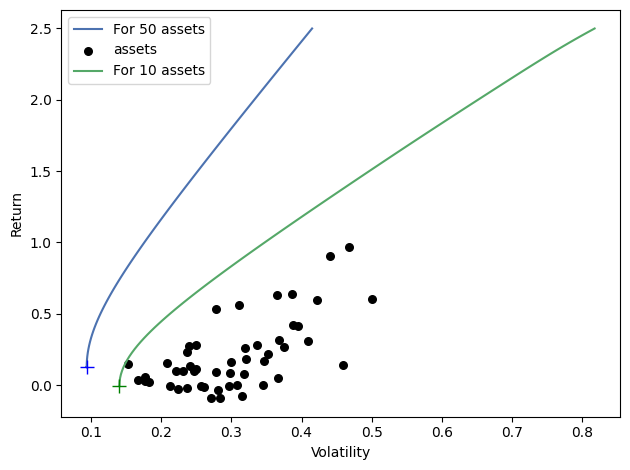

In [ ]:
df_stocks= yf.download(tickers_10_short, start="2016-01-01", end="2016-12-31")['Adj Close']
df_stocks.head()
nullin_df = pd.DataFrame(df_stocks,columns=tickers_10_short)
#Годовая доходность
mu10_s = expected_returns.mean_historical_return(df_stocks)
#Дисперсия портфеля
Sigma10_s = risk_models.sample_cov(df_stocks)
ef10_s = EfficientFrontier(mu10_s, Sigma10_s, weight_bounds=(-1,1))
minvol=ef10_s.min_volatility()
minvol_pwt=ef10_s.clean_weights()
ef10_s.portfolio_performance(verbose=True)
performance = ef10_s.portfolio_performance()
return10_s, volatility10_s = performance[:2]

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef50_s, ax=ax, show_assets=True, ef_param_range=np.linspace(0.00, 2.50, 100))
ef10_s = EfficientFrontier(mu10_s, Sigma10_s, weight_bounds=(-1,1))
plotting.plot_efficient_frontier(ef10_s, ax=ax, show_assets=False, ef_param_range=np.linspace(0.00, 2.50, 100))
plt.plot([volatility50_s], [return50_s], marker='+', color='blue', markerfacecolor='red', markersize=10)
plt.plot([volatility10_s], [return10_s], marker='+', color='green', markerfacecolor='red', markersize=10)
plt.legend(['For 50 assets','assets', 'For 10 assets'])
#plt.savefig('Efficient_frontiers_t3_s.png')
plt.show()

При включении в портфель всех 50 активов у вас есть больше возможностей для оптимизации риска и доходности, что приводит к более высокой доходности при том же уровне риска. Доходность портфеля с минимальным риском из 10 акций сильно мала возможно из-за того, что акции могут быть недостаточно диверсифицированными.

Случай, когда короткие продажи запрещены:

[*********************100%***********************]  10 of 10 completed


Expected annual return: 23.5%
Annual volatility: 20.2%
Sharpe Ratio: 1.06


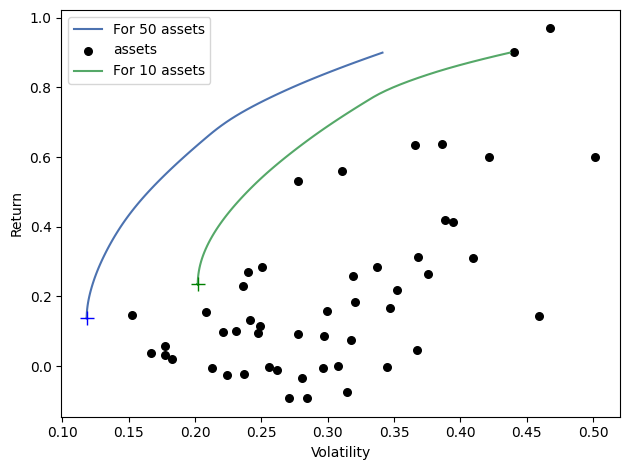

In [ ]:
df_stocks= yf.download(tickers_10_long, start="2016-01-01", end="2016-12-31")['Adj Close']
df_stocks.head()
nullin_df = pd.DataFrame(df_stocks,columns=tickers_10_long)
#Годовая доходность
mu10_l = expected_returns.mean_historical_return(df_stocks)
#Дисперсия портфеля
Sigma10_l = risk_models.sample_cov(df_stocks)
ef10_l = EfficientFrontier(mu10_l, Sigma10_l, weight_bounds=(0,1))
minvol=ef10_l.min_volatility()
minvol_pwt=ef10_l.clean_weights()
ef10_l.portfolio_performance(verbose=True)
performance = ef10_l.portfolio_performance()
return10_l, volatility10_l = performance[:2]

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef50_l, ax=ax, show_assets=True, ef_param_range=np.linspace(0.00, 0.90, 100))
ef10_l = EfficientFrontier(mu10_l, Sigma10_l, weight_bounds=(0,1))
plotting.plot_efficient_frontier(ef10_l, ax=ax, show_assets=False, ef_param_range=np.linspace(0.00, 0.90, 100))
plt.plot([volatility50_l], [return50_l], marker='+', color='blue', markerfacecolor='red', markersize=10)
plt.plot([volatility10_l], [return10_l], marker='+', color='green', markerfacecolor='red', markersize=10)
plt.legend(['For 50 assets','assets', 'For 10 assets'])
#plt.savefig('Efficient_frontiers_t3_l.png')
plt.show()

Здесь снова эффективный фронт для 50 активов поднимается выше, чем фронт для 10 активов, что указывает на более широкие возможности оптимизации для портфеля с большим количеством активов.Примечательно, что риск и доходность портфеля из 10 активов практически равны (20.2% риска и 23.5% доходности). Это говорит о том, что сокращение количества активов всё же позволило достичь приличного уровня эффективности, хотя и не такого высокого, как в случае с 50 активами.

## **Risk aversion**